# Project: Exploring a Soccer Match Database

John Meehan

May 21, 2019

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

I have chosen to analyze the [European Soccer Database](https://www.kaggle.com/hugomathien/soccer). The database includes approximately 26,000 records of soccer matches, including team layout and game outcome. There is also data regarding player and team attributes (taken from the FIFA video games), and values for betting odds on each game across several online gambling platforms.

My focus will be on the players making up each team, team formations, and their respective impacts on team performance. Through this project, I will attempt to draw conclusions about factors influencing team performance based on the available data.

I chose this database and to focus on performance because of the connection with my work background. I am interested in improving the performance of a manufacturing organization which produces only custom made-to-order products. I would like to draw a parallel between analyzing team sport performance and team business performance.

### Importing

First I import the packages relevant for this project:

In [1]:
import sqlite3                                       # to read the raw database file in .sqlite format
import pandas as pd                                  # for creating and modifying dataframes
import matplotlib                                    # for miscellaneous visualization tools
import matplotlib.pyplot as plt                      # for data visualization
import matplotlib.pyplot as plt                      # to plot findings
import os                                            # to locate files within the directory
import numpy as np                                   # for numpy arrays, general math functions
from sklearn import preprocessing                    # for scaling data
from sklearn.neighbors import KNeighborsClassifier   # for classifying team formations

%matplotlib inline
%config InlineBackend.figure_format ='retina'

<a id='wrangling'></a>
## Data Wrangling

The file comes in .sqlite format, so it must be unpacked and imported into dataframes to be manipulated. Below, I will check out what data is included with each table and begin to shape the data so that it is useful for my analysis.

### General Properties

In [2]:
path = os.getcwd()                     # ensures that the full path is being used
database = path + '\\database.sqlite'  # even though the file should be in the same folder

con = sqlite3.connect(database)        # establish a connection with the database
tables = pd.read_sql(                  # write a query to see all tables
    """
    SELECT * FROM sqlite_master
    WHERE type='table';
    """,con=con)
tables

,type,name,tbl_name,rootpage,sql
0,table,sqlite_sequence,sqlite_sequence,4,"CREATE TABLE sqlite_sequence(name,seq)"
1,table,Player_Attributes,Player_Attributes,11,"CREATE TABLE ""Player_Attributes"" (\n\t`id`\tIN..."
2,table,Player,Player,14,CREATE TABLE `Player` (\n\t`id`\tINTEGER PRIMA...
3,table,Match,Match,18,CREATE TABLE `Match` (\n\t`id`\tINTEGER PRIMAR...
4,table,League,League,24,CREATE TABLE `League` (\n\t`id`\tINTEGER PRIMA...
5,table,Country,Country,26,CREATE TABLE `Country` (\n\t`id`\tINTEGER PRIM...
6,table,Team,Team,29,"CREATE TABLE ""Team"" (\n\t`id`\tINTEGER PRIMARY..."
7,table,Team_Attributes,Team_Attributes,2,CREATE TABLE `Team_Attributes` (\n\t`id`\tINTE...


### Tables
I know from reading the documentation provided with the database that the 2 `_Attributes` tables are based on data from the FIFA video games. I will not need them to support my analysis, so they will not be brought into dataframes. 

I originally included queries for the league, player, and team tables; however, my analysis did not end up requiring that data so I have removed them for clarity & code performance.

In [3]:
match_df = pd.read_sql(
    """
    SELECT * FROM match;
    """, con=con, index_col='id', parse_dates=['date'])

match_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25979 entries, 1 to 25979
Columns: 114 entries, country_id to BSA
dtypes: datetime64[ns](1), float64(96), int64(8), object(9)
memory usage: 22.8+ MB


One of the first issues I will need to tackle is reducing the amount of columns in this table. The above output shows that there are 114 columns, too many to be listed using `.info()`. I will need to print a list of the columns to take a look.

### Data Cleaning

In [4]:
for num, column in enumerate(list(match_df)):
    print('%i: %s' % (num,column))

0: country_id
1: league_id
2: season
3: stage
4: date
5: match_api_id
6: home_team_api_id
7: away_team_api_id
8: home_team_goal
9: away_team_goal
10: home_player_X1
11: home_player_X2
12: home_player_X3
13: home_player_X4
14: home_player_X5
15: home_player_X6
16: home_player_X7
17: home_player_X8
18: home_player_X9
19: home_player_X10
20: home_player_X11
21: away_player_X1
22: away_player_X2
23: away_player_X3
24: away_player_X4
25: away_player_X5
26: away_player_X6
27: away_player_X7
28: away_player_X8
29: away_player_X9
30: away_player_X10
31: away_player_X11
32: home_player_Y1
33: home_player_Y2
34: home_player_Y3
35: home_player_Y4
36: home_player_Y5
37: home_player_Y6
38: home_player_Y7
39: home_player_Y8
40: home_player_Y9
41: home_player_Y10
42: home_player_Y11
43: away_player_Y1
44: away_player_Y2
45: away_player_Y3
46: away_player_Y4
47: away_player_Y5
48: away_player_Y6
49: away_player_Y7
50: away_player_Y8
51: away_player_Y9
52: away_player_Y10
53: away_player_Y11
54: home_p

It looks like I will want to lose all of the columns after 75, because they contain metrics that I am not interested in for this analysis. In this case, I find it much easier to lose the columns within Pandas rather than SQL, because I want to use a numbered range.

In [5]:
# Drop columns by index
match_df = match_df[match_df.columns[:76]]
match_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25979 entries, 1 to 25979
Data columns (total 76 columns):
country_id          25979 non-null int64
league_id           25979 non-null int64
season              25979 non-null object
stage               25979 non-null int64
date                25979 non-null datetime64[ns]
match_api_id        25979 non-null int64
home_team_api_id    25979 non-null int64
away_team_api_id    25979 non-null int64
home_team_goal      25979 non-null int64
away_team_goal      25979 non-null int64
home_player_X1      24158 non-null float64
home_player_X2      24158 non-null float64
home_player_X3      24147 non-null float64
home_player_X4      24147 non-null float64
home_player_X5      24147 non-null float64
home_player_X6      24147 non-null float64
home_player_X7      24147 non-null float64
home_player_X8      24147 non-null float64
home_player_X9      24147 non-null float64
home_player_X10     24147 non-null float64
home_player_X11     24147 non-null float6

From looking at the remaining columns, I can see that many of the rows contain null values.

Below I will drop any rows containing null values using the `dropna` function.

In [6]:
match_df.dropna(how='any',inplace=True)

In [7]:
match_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21361 entries, 146 to 25979
Data columns (total 76 columns):
country_id          21361 non-null int64
league_id           21361 non-null int64
season              21361 non-null object
stage               21361 non-null int64
date                21361 non-null datetime64[ns]
match_api_id        21361 non-null int64
home_team_api_id    21361 non-null int64
away_team_api_id    21361 non-null int64
home_team_goal      21361 non-null int64
away_team_goal      21361 non-null int64
home_player_X1      21361 non-null float64
home_player_X2      21361 non-null float64
home_player_X3      21361 non-null float64
home_player_X4      21361 non-null float64
home_player_X5      21361 non-null float64
home_player_X6      21361 non-null float64
home_player_X7      21361 non-null float64
home_player_X8      21361 non-null float64
home_player_X9      21361 non-null float64
home_player_X10     21361 non-null float64
home_player_X11     21361 non-null floa

We can now see that each of the columns contains the same number of non-null entries, so there are no empty fields. There are still over 21,000 records even after being selective with the data, which should be plenty for this analysis.

<a id='eda'></a>
## Exploratory Data Analysis: Which team formations are the most effective?

Because each match comes with the position of each player on the field, both home and away, it begs the question: is there a truly optimal formation? 

Surely coaches decide on formations based on their team's strengths and strategy, but perhaps some objective data could help drive better decision-making.

**In order to attempt to answer this question, I will need to:**
<li><a href="#def_class">Define how team formations will be classified</a></li>
<li><a href="#classify">Classify both teams' positions for each match</a></li>
<li><a href="#def_success">Decide on a variable to quantify 'success'</a></li>
<li><a href="#Conclusions">Determine if any position is correlated with success</a></li>

<a id='def_class'></a>
### 1. Define the Classification of Team Formations

Although I grew up playing soccer, I have little intrinsic understanding of how team formations are defined or why. For the purposes of this exercise, I have sourced definitions of 8 popular team formations from [this article from "Soccer Training Guide"](http://www.soccer-training-guide.com/soccer-formations.html).


**Example: 4-4-2 Formation:**
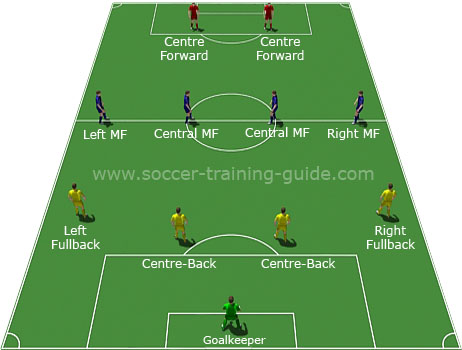

As a disclaimer, I built these formation arrays somewhat arbitrarily by looking at how the team positions were defined in the database, and picking points to align with how the formation was described. In the future, this could be scrutinized a bit more.

I will go into more detail below, but I decided to simplify the classification process by converting each player position into a magnitude to make classification easier.

Here I take all 8 popular team formations, import them into a DataFrame, and convert them into magnitudes.

In [8]:
# define popular team formation arrays
pop_form_arrays = {1:['4-4-2',[1,1],[2,3],[4,3],[6,3],[8,3],[2,7],[4,7],[6,7],[8,7],[4,10],[6,10]],
                   2:['4-3-3',[1,1],[2,3],[4,3],[6,3],[8,3],[3,7],[5,7],[7,7],[3,10],[5,10],[7,10]],
                   3:['3-4-3',[1,1],[3,3],[5,3],[7,3],[2,7],[4,7],[6,7],[8,7],[3,10],[5,10],[7,10]],
                   4:['3-6-1',[1,1],[3,3],[5,3],[7,3],[1,7],[3,7],[4,7],[6,7],[7,7],[9,7],[5,9]],
                   5:['3-4-2-1',[1,1],[3,3],[5,3],[7,3],[2,7],[4,7],[6,7],[8,7],[4,9],[6,9],[5,10]],
                   6:['4-5-1',[1,1],[2,3],[4,3],[6,3],[8,3],[1,7],[3,7],[5,7],[7,7],[9,7],[5,10]],
                   7:['5-2-2-1',[1,1],[1,3],[3,3],[5,3],[7,3],[9,3],[4,5],[6,5],[4,7],[6,7],[5,11]],
                   8:['3-5-2',[1,1],[3,3],[5,3],[7,3],[1,7],[3,7],[5,7],[7,7],[9,7],[4,10],[6,10]]}

# name the dataframe series
cols = ['form_name','mag_1','mag_2','mag_3','mag_4','mag_5','mag_6','mag_7','mag_8','mag_9','mag_10','mag_11']
# transpose to get it into the proper format for analysis
# each formation should be a 'sample', each position magnitude should be a variable
pop_form_df = pd.DataFrame(data=pop_form_arrays).T
pop_form_df.columns = cols

# 'normalize', or find the magnitude of, each coordinate point
pop_form_mags = pop_form_df[cols[1:12]].applymap(lambda x: np.linalg.norm(x))
pop_form_mags = pop_form_mags.values
# check the output
pop_form_mags[0]

array([ 1.41421356,  3.60555128,  5.        ,  6.70820393,  8.54400375,
        7.28010989,  8.06225775,  9.21954446, 10.63014581, 10.77032961,
       11.66190379])

<a id='classify'></a>
### 2. Classify Both Team Formations

Now I will create a copy of `match_df` in order to manipulate the data into a format that can be classified. With the copied version, I can remove any remaining fields that are not necessary for formation classification.

In [9]:
# create dedicated dataframe of home & away team formations
form_class_df = match_df.copy()
form_class_df = form_class_df[form_class_df.columns[5:54]]
form_class_df.drop(['home_team_api_id','away_team_api_id','home_team_goal','away_team_goal'],axis=1,inplace=True)
form_class_df.info()

# remove player positions from match dataframe
match_df.drop(match_df.filter(regex='_player', axis=1),axis=1,inplace=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21361 entries, 146 to 25979
Data columns (total 45 columns):
match_api_id       21361 non-null int64
home_player_X1     21361 non-null float64
home_player_X2     21361 non-null float64
home_player_X3     21361 non-null float64
home_player_X4     21361 non-null float64
home_player_X5     21361 non-null float64
home_player_X6     21361 non-null float64
home_player_X7     21361 non-null float64
home_player_X8     21361 non-null float64
home_player_X9     21361 non-null float64
home_player_X10    21361 non-null float64
home_player_X11    21361 non-null float64
away_player_X1     21361 non-null float64
away_player_X2     21361 non-null float64
away_player_X3     21361 non-null float64
away_player_X4     21361 non-null float64
away_player_X5     21361 non-null float64
away_player_X6     21361 non-null float64
away_player_X7     21361 non-null float64
away_player_X8     21361 non-null float64
away_player_X9     21361 non-null float64
away_play

In [10]:
# create a list of the columns relating to home player positions
home_x_cols = form_class_df.filter(regex='home_player_X', axis=1)
home_y_cols = form_class_df.filter(regex='home_player_Y', axis=1)
home_array = list(map(list, zip(home_x_cols,home_y_cols)))

# create a list of the columns relating to away player positions
away_x_cols = form_class_df.filter(regex='away_player_X', axis=1)
away_y_cols = form_class_df.filter(regex='away_player_Y', axis=1)
away_array = list(map(list, zip(away_x_cols,away_y_cols)))
away_array

[['away_player_X1', 'away_player_Y1'],
 ['away_player_X2', 'away_player_Y2'],
 ['away_player_X3', 'away_player_Y3'],
 ['away_player_X4', 'away_player_Y4'],
 ['away_player_X5', 'away_player_Y5'],
 ['away_player_X6', 'away_player_Y6'],
 ['away_player_X7', 'away_player_Y7'],
 ['away_player_X8', 'away_player_Y8'],
 ['away_player_X9', 'away_player_Y9'],
 ['away_player_X10', 'away_player_Y10'],
 ['away_player_X11', 'away_player_Y11']]

Below I quickly illustrate the basis for reducing the player positions to magnitudes.

I will be classifying the team formations using a 'Nearest-Neighbors' algorithm which requires variables to be a list of scalar values; therefore I cannot pass coordinate pairs into the classifier. I also do not want to pass a flattened list of all of the player position values (i.e. `home_player_x1, home_player_y1, home_player_x2, home_player_y2` etc.) because it seems that some information would be lost as to the exact arrangement of the players on the field.

Instead, I turn each `x, y` coordinate pair into a magnitude: $(x^{2} + y^{2})^{1/2}$, which for the purposes of this exercise will provide enough of a unique value for each player location to be able to accurately make a match for a formation.

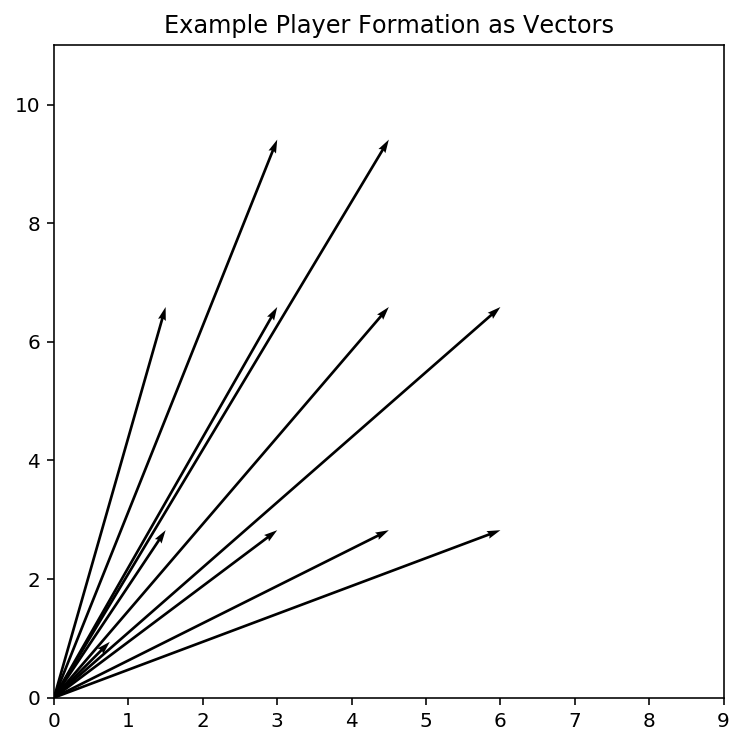

In [11]:
vectors = pop_form_df[cols[1:12]].values.flatten().tolist()[:11]
X = [i[0] for i in vectors]
Y = [i[1] for i in vectors]
x, y = [0],[0] # origin point

fig, ax = plt.subplots(figsize=(6,6))
ax.set_xlim(0, 9)
ax.set_ylim(0, 11)
ax.quiver(x, y, X, Y, scale=12, width=.004)
ax.set_title('Example Player Formation as Vectors')
plt.show()

In [12]:
# define a function to convert the player positions into an array of coordinate pairs
# pairs are then converted into magnitudes and returned as a dataframe
# the index is then matched to the main dataframe so they can be relinked later

# takes either 'home_array' or 'away_array'
def formation_magnitudes(input_array):
    # holds player coordinates
    player_temp = []
    # holds array of coordinates
    team_temp = []
    
    for row in input_array:
        # zips together the X and Y coordinates for each player
        player_temp = list(map(list, zip(form_class_df[row[0]], form_class_df[row[1]])))
        # builds a team array over the iteration
        team_temp.append(player_temp)
        
    formation_array = np.array(list(map(list, zip(*team_temp))))
    formation_mags = np.array([[np.linalg.norm(pair) for pair in array] for array in formation_array])
    formation_mags_df = pd.DataFrame().append(formation_mags.tolist())
    formation_mags_df = formation_mags_df.set_index(form_class_df.index)
    return formation_mags_df

In [13]:
# build dataframe for the home team for all matches
home_player_mags = formation_magnitudes(home_array)
# build dataframe for the away team for all matches
away_player_mags = formation_magnitudes(away_array)

Now I will process and scale the magnitude of the popular formations so that they can be passed as the features in my Nearest-Neighbors algorithm.

In [14]:
# define scaler
scaler = preprocessing.StandardScaler()
# scale the magnitudes of player positions in popular formations
scaler.fit(pop_form_mags)
feature = scaler.transform(pop_form_mags)
# verify output is centered around 0
feature.tolist()[0]

[0.0,
 -0.6614397602336219,
 -0.5724818079403233,
 -0.5513194400863036,
 1.251185956647497,
 -0.8216275325657859,
 -0.18596617646848015,
 -0.2944913539548302,
 0.6127813354423037,
 -0.109326622626076,
 0.16668793609720792]

I create scalar labels for each of the formation arrays:

In [15]:
le = preprocessing.LabelEncoder()
label = le.fit_transform(pop_form_df['form_name'])
label

array([5, 4, 1, 3, 0, 6, 7, 2], dtype=int64)

Finally, I pass the `home_player_mags` and `away_player_mags` arrays into the classifier to receive a closest approximation label for how we should classify the formation:

In [16]:
X = feature.tolist()
model = KNeighborsClassifier(n_neighbors=1)
model.fit(X,label)
home_sample = scaler.transform(home_player_mags)
home_predicted = model.predict(home_sample)
print(home_predicted)
away_sample = scaler.transform(away_player_mags)
away_predicted = model.predict(away_sample)
print(away_predicted)

[5 5 5 ... 1 5 5]
[5 5 5 ... 4 5 5]


In [17]:
form_class_df['home_formation_id'] = np.array(home_predicted)
form_class_df['away_formation_id'] = np.array(away_predicted)
form_class_df[['home_formation_id','away_formation_id']].describe()

,home_formation_id,away_formation_id
count,21361.000000,21361.000000
mean,4.602874,4.610131
std,1.061370,1.086415
min,0.000000,0.000000
25%,4.000000,4.000000
50%,5.000000,5.000000
75%,5.000000,5.000000
max,7.000000,7.000000


At a glance we can see that we have a range of formation types for all of the matches, and there is certainly a quantifiable difference between team formations at home and away.

In [18]:
form_name_dict = dict(zip(label,pop_form_df['form_name']))
form_class_df.drop(form_class_df.filter(regex='_player', axis=1),axis=1,inplace=True)
form_class_df.head(5)

,match_api_id,home_formation_id,away_formation_id
id,,,
146,493017,5,5
154,493025,5,5
156,493027,5,5
163,493034,5,5
169,493040,5,5


In [19]:
form_class_df[['home_formation_desc','away_formation_desc']] = form_class_df[['home_formation_id','away_formation_id']].replace(form_name_dict,inplace=False)
print(form_class_df['home_formation_desc'].value_counts(sort=True))
print(form_class_df['away_formation_desc'].value_counts(sort=True))

4-4-2      12564
4-3-3       5156
4-5-1       1764
3-5-2        983
3-4-3        583
5-2-2-1      242
3-4-2-1       52
3-6-1         17
Name: home_formation_desc, dtype: int64
4-4-2      12165
4-3-3       5222
4-5-1       1974
3-5-2       1033
3-4-3        568
5-2-2-1      318
3-4-2-1       61
3-6-1         20
Name: away_formation_desc, dtype: int64


By taking occurrence counts of each formation type, I validated the assertion that the '4-4-2' formation is by far the most popular in modern soccer. Interestingly, all 8 formation types, including some of the stranger ones, did see occasional use throughout the data set.

<a id='def_success'></a>
### 3. Defining Team Success

The metric defining team success will be `Score_Delt`, defined as follows:
```
Score_Delt = home_team_goal - away_team_goal
```
Therefore, a positive `Score_Delt` indicates a home team win, and a negative `Score_Delt` indicates an away team win.

Then I define a qualitative variable `Outcome`, which results from binning `Score_Delt` into "home win/tie/away win" categories.

In [20]:
# Add a column for the difference between home & away goals scored
match_df['Score_Delt'] = match_df['home_team_goal']-match_df['away_team_goal']

# Add another column specifying if the home or away team won
bins = [np.NINF, -0.1, 0.1, np.Inf]
match_df['Outcome'] = pd.cut(match_df['Score_Delt'], bins, labels=['away','tie','home'], include_lowest=True)

# Verify that the output makes sense
match_df[['home_team_goal','away_team_goal','Score_Delt','Outcome']].head(5)

,home_team_goal,away_team_goal,Score_Delt,Outcome
id,,,,
146,2,1,1,home
154,1,3,-2,away
156,2,0,2,home
163,2,1,1,home
169,0,0,0,tie


Now, I join the `Score_Delt` variable on the `form_class_df` DataFrame that I constructed to classify team formations.

With these two variables in the same DataFrame, I will be able to assess the success of different team formations.

In [21]:
form_class_df = form_class_df.join(match_df['Score_Delt'])
form_class_df.head(5)

,match_api_id,home_formation_id,away_formation_id,home_formation_desc,away_formation_desc,Score_Delt
id,,,,,,
146,493017,5,5,4-4-2,4-4-2,1
154,493025,5,5,4-4-2,4-4-2,-2
156,493027,5,5,4-4-2,4-4-2,2
163,493034,5,5,4-4-2,4-4-2,1
169,493040,5,5,4-4-2,4-4-2,0


Below, I quickly plot a histogram of the "Score Delta" outcomes of all matches, as well as compute the skew and mean of the Dataset. 

Based on a few quick statistics, we can confirm what the histogram demonstrates visually: the data is right-skewed; i.e., the home team tends to win in most games.

Skew: 0.05
Mean: 0.38


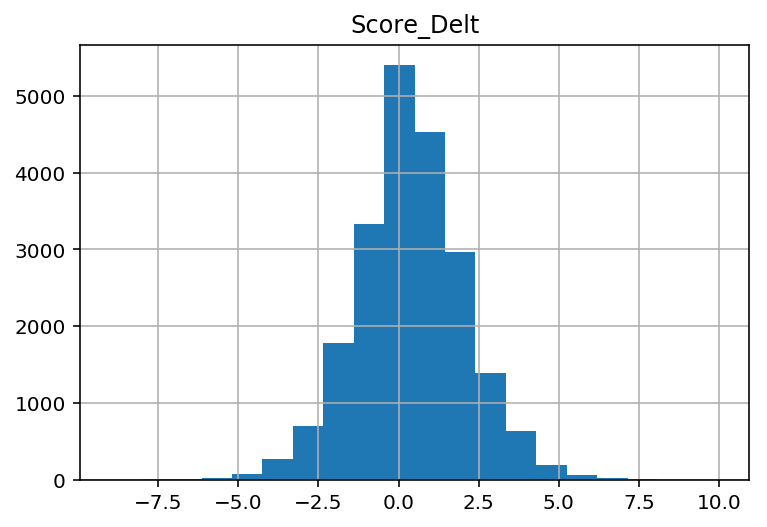

In [22]:
print('Skew: %.2f' % form_class_df['Score_Delt'].skew())
print('Mean: %.2f' % form_class_df['Score_Delt'].mean())
form_class_df.hist(column='Score_Delt', bins=form_class_df['Score_Delt'].nunique());

I investigate this result a bit further by calculating the chance of winning for all three possible game outcomes. 

In [23]:
home_win = match_df.query('Outcome == "home"').count()[0]/match_df['Outcome'].count()
tie = match_df.query('Outcome == "tie"').count()[0]/match_df['Outcome'].count()
away_win = match_df.query('Outcome == "away"').count()[0]/match_df['Outcome'].count()
print('Percent Chance of Winning at Home: %.2f%%' % (100*home_win))
print('Percent Chance of Winning Away: %.2f%%' % (100*away_win))
print('Percent Chance of a Tie: %.2f%%' % (100*tie))

Percent Chance of Winning at Home: 45.90%
Percent Chance of Winning Away: 28.84%
Percent Chance of a Tie: 25.26%


Winning at home is by far the most likely outcome.

Taking this into account, I want to understand which formations minimize the chance of losing while away and maximize the chance of winning at home. It may seem like a trivial distinction, but I don't want to rule out the possibility that a different formation may be more effective in one scenario than another.

To visualize this, I plot histograms of `Score_Delt` for each team formation, overlaying the distributions for home and away teams. I place a line and label at the mean `Score_Delt` for each.

**Note:** For the 'Away Team' histograms, I invert `Score_Delt`, so that the plot is visually consistent; the larger the mean, the better.

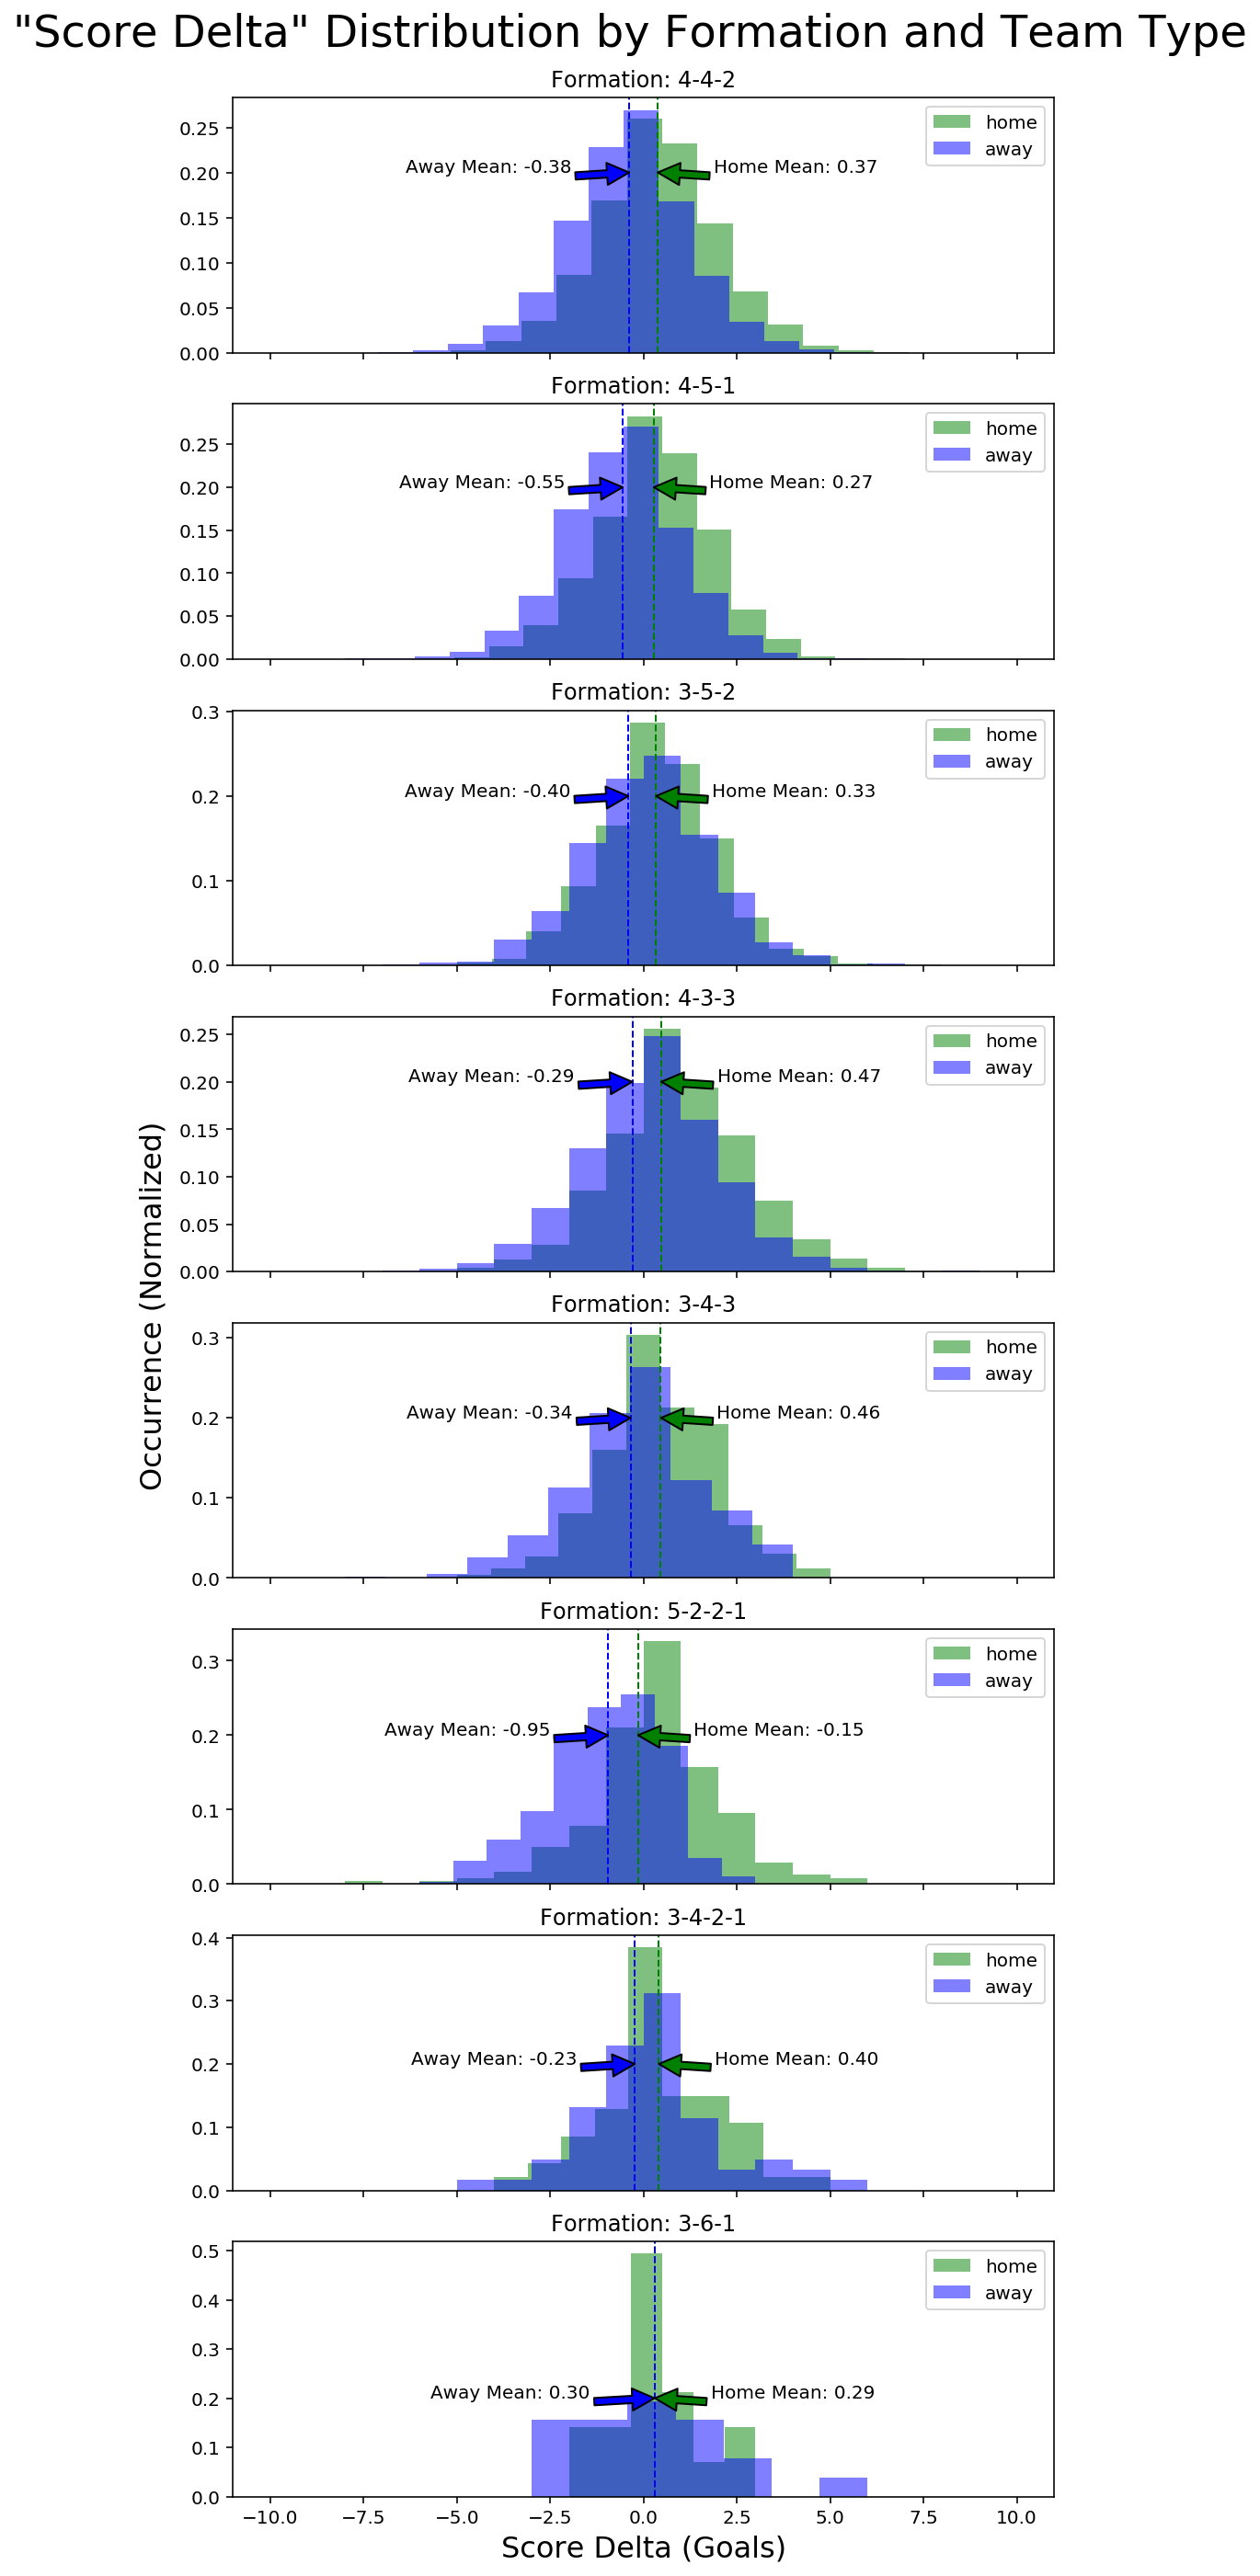

In [24]:
fig,ax = plt.subplots(8, 1, sharex='col', figsize=(8, 24))
form_balance = {}

axes = ax.flatten()
for i, j in zip(form_class_df['home_formation_id'].unique(), axes):
    home_values = form_class_df['Score_Delt'].loc[form_class_df['home_formation_id'] == i]
    home_mean = home_values.mean()
    j.hist(home_values,bins=home_values.nunique(),density=True, color='g', alpha=0.5, label='home')
    j.axvline(home_mean, color='g', linestyle='dashed', linewidth=1)
    j.annotate('Home Mean: %.2f' % home_mean, xy=(home_mean,0.2), xytext=(home_mean+1.5,0.2), arrowprops=dict(facecolor='green', shrink=0.005),)
    
    away_values = -form_class_df['Score_Delt'].loc[form_class_df['away_formation_id'] == i]
    away_mean = away_values.mean()
    j.hist(away_values,bins=away_values.nunique(),density=True, color='b', alpha=0.5, label='away')
    j.axvline(away_mean, color='b', linestyle='dashed', linewidth=1)
    j.set_title('Formation: %s' % form_name_dict.get(i))
    j.annotate('Away Mean: %.2f' % away_mean, xy=(away_mean,0.2), xytext=(away_mean-6,0.2), arrowprops=dict(facecolor='blue', shrink=0.005),)
    j.legend()
    
    form_balance[form_name_dict.get(i)] = abs(abs(home_mean)-abs(away_mean))


fig.text(0.05, 0.5, 'Occurrence (Normalized)', ha='center', va='center', rotation='vertical', fontsize=16)
plt.xlabel('Score Delta (Goals)', fontsize=16)
fig.text(0.5, 0.9, '"Score Delta" Distribution by Formation and Team Type', ha='center', va='center', fontsize=24);


<a id='conclusions'></a>
## Conclusions

My analysis of over 21,000 soccer matches indicates that although the '4-4-2' formation is by far the most popular, the most effective team formation is actually the '4-3-3'.

**Note:** Although the '3-6-1' and '3-4-2-1' formations have the best away score means, the sample sizes are very small, so I must discount them for the purpose of this conclusion.

The '4-3-3' formation has the highest mean `Score_Delta` for both home and away teams, at -0.29 and 0.47 respectively.

Another interesting trait I observed from looking at the performance of each team formation, is what I will call 'formation balance', where: $form\_balance=||home\_mean|-|away\_mean||$

In [25]:
sorted_balance = sorted(form_balance.items(), key=lambda kv: kv[1])
sorted_balance

[('4-4-2', 0.005518517079114771),
 ('3-6-1', 0.00588235294117645),
 ('3-5-2', 0.07615917844400305),
 ('3-4-3', 0.11985722223564371),
 ('4-3-3', 0.17386807737985055),
 ('3-4-2-1', 0.17433795712484237),
 ('4-5-1', 0.28505089979254117),
 ('5-2-2-1', 0.7936483185196737)]

The closer the value is to zero, the more evenly matched the home & away teams are when using the formation. Here we can see that the popular '4-4-2' formation is the most evenly matched out of all 8 formations, followed closely by '3-6-1'.

The most unbalanced formation is the '5-2-2-1', which actually has the worst performance of all team formations for both home and away formations.

In [27]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])

4294967295